# DataSprints Case

In [1]:
# Import libs
%matplotlib inline
import pandas as pd
import seaborn as sns
import utils
import calendar
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib import dates
pd.options.display.max_colwidth = 1000
pd.set_option('display.max_rows', 18000)

In [2]:
# Connect to database
database_access = utils.get_database_access()
airflow_handler = utils.DatabaseHandler(database_access["airflow"])

## Quesitos Minimos

### Qual a distância média percorrida por viagens com no máximo 2 passageiros

In [3]:
# Fetch Query Airflow
query_2_passengers = f"""
    select trip_distance
    from nyc_taxi.nyctaxi_trips
    where passenger_count <= 2
    and trip_distance > 0
"""
# Run Query
two_passenger = pd.DataFrame(airflow_handler.fetch(query_2_passengers))

In [4]:
trip_distance_describe = two_passenger['trip_distance'].describe()
print(f'Total de viagens feitas com ate 2 passageiros: {int(trip_distance_describe[0])}')
print(f'Kilometragem media de viagens feitas com ate 2 passageiros: {round(trip_distance_describe[1], 2)}')
print(f'Kilometragem minima de viagens feitas com ate 2 passageiros: {trip_distance_describe[3]}')
print(f'Kilometragem maxima de viagens feitas com ate 2 passageiros: {trip_distance_describe[7]}')

Total de viagens feitas com ate 2 passageiros: 3288172
Kilometragem media de viagens feitas com ate 2 passageiros: 2.69
Kilometragem minima de viagens feitas com ate 2 passageiros: 0.002
Kilometragem maxima de viagens feitas com ate 2 passageiros: 49.7


### Quais os 3 maiores ​ vendors ​ em quantidade total de dinheiro arrecadado

In [5]:
# Fetch Query Airflow
query_3_big_vendors = f"""
    select vendor_id
        ,sum(trip_distance) as trip_distance
        ,sum(total_amount) as total_amount
        ,sum(tip_amount) as tip_amount
    from nyc_taxi.nyctaxi_trips
    group by vendor_id
    order by total_amount desc
    limit 3;
"""
# Run Query
big_vendors = pd.DataFrame(airflow_handler.fetch(query_3_big_vendors))

In [6]:
big_vendors['total_amount'] = big_vendors['total_amount'].apply(lambda data: float('%.5f' % data))

In [7]:
big_vendors

vendor_id  trip_distance  total_amount  tip_amount
0       CMT    5055149.812   19549084.28   718470.60
1       VTS    4933539.400   19043434.00   825853.96
2       DDS     724132.800    2714901.72    89835.52

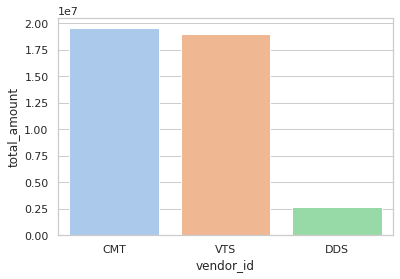

In [8]:
sns.set(style="whitegrid")
ax = sns.barplot(x='vendor_id', y='total_amount', data=big_vendors, palette="pastel")

### Faça um histograma da distribuição mensal, nos 4 anos, de corridas pagas em dinheiro;

In [9]:
# Fetch Query Airflow
query_monthly_distribution = f"""
    with date_month as (
        select to_char(date_trunc('month', to_date(pickup_datetime, 'YYYY-MM-DD')), 'Month') as month_date
              ,extract(month from date_trunc('month', to_date(pickup_datetime, 'YYYY-MM-DD'))) as month_number
              ,extract(year from date_trunc('month', to_date(pickup_datetime, 'YYYY-MM-DD'))) as year_date
              ,sum(total_amount) as total_amount
              ,lower(payment_type) as payment_type 
        from nyc_taxi.nyctaxi_trips
        where lower(payment_type) = 'cash'
        group by month_date
                ,year_date
                ,lower(payment_type)
                ,month_number
    )select concat(trim(month_date), '-', year_date) as date
          ,total_amount
          ,payment_type 
          ,month_number
    from date_month
    order by year_date asc, month_number asc;
"""
# Run Query
monthly_distribution = pd.DataFrame(airflow_handler.fetch(query_monthly_distribution))

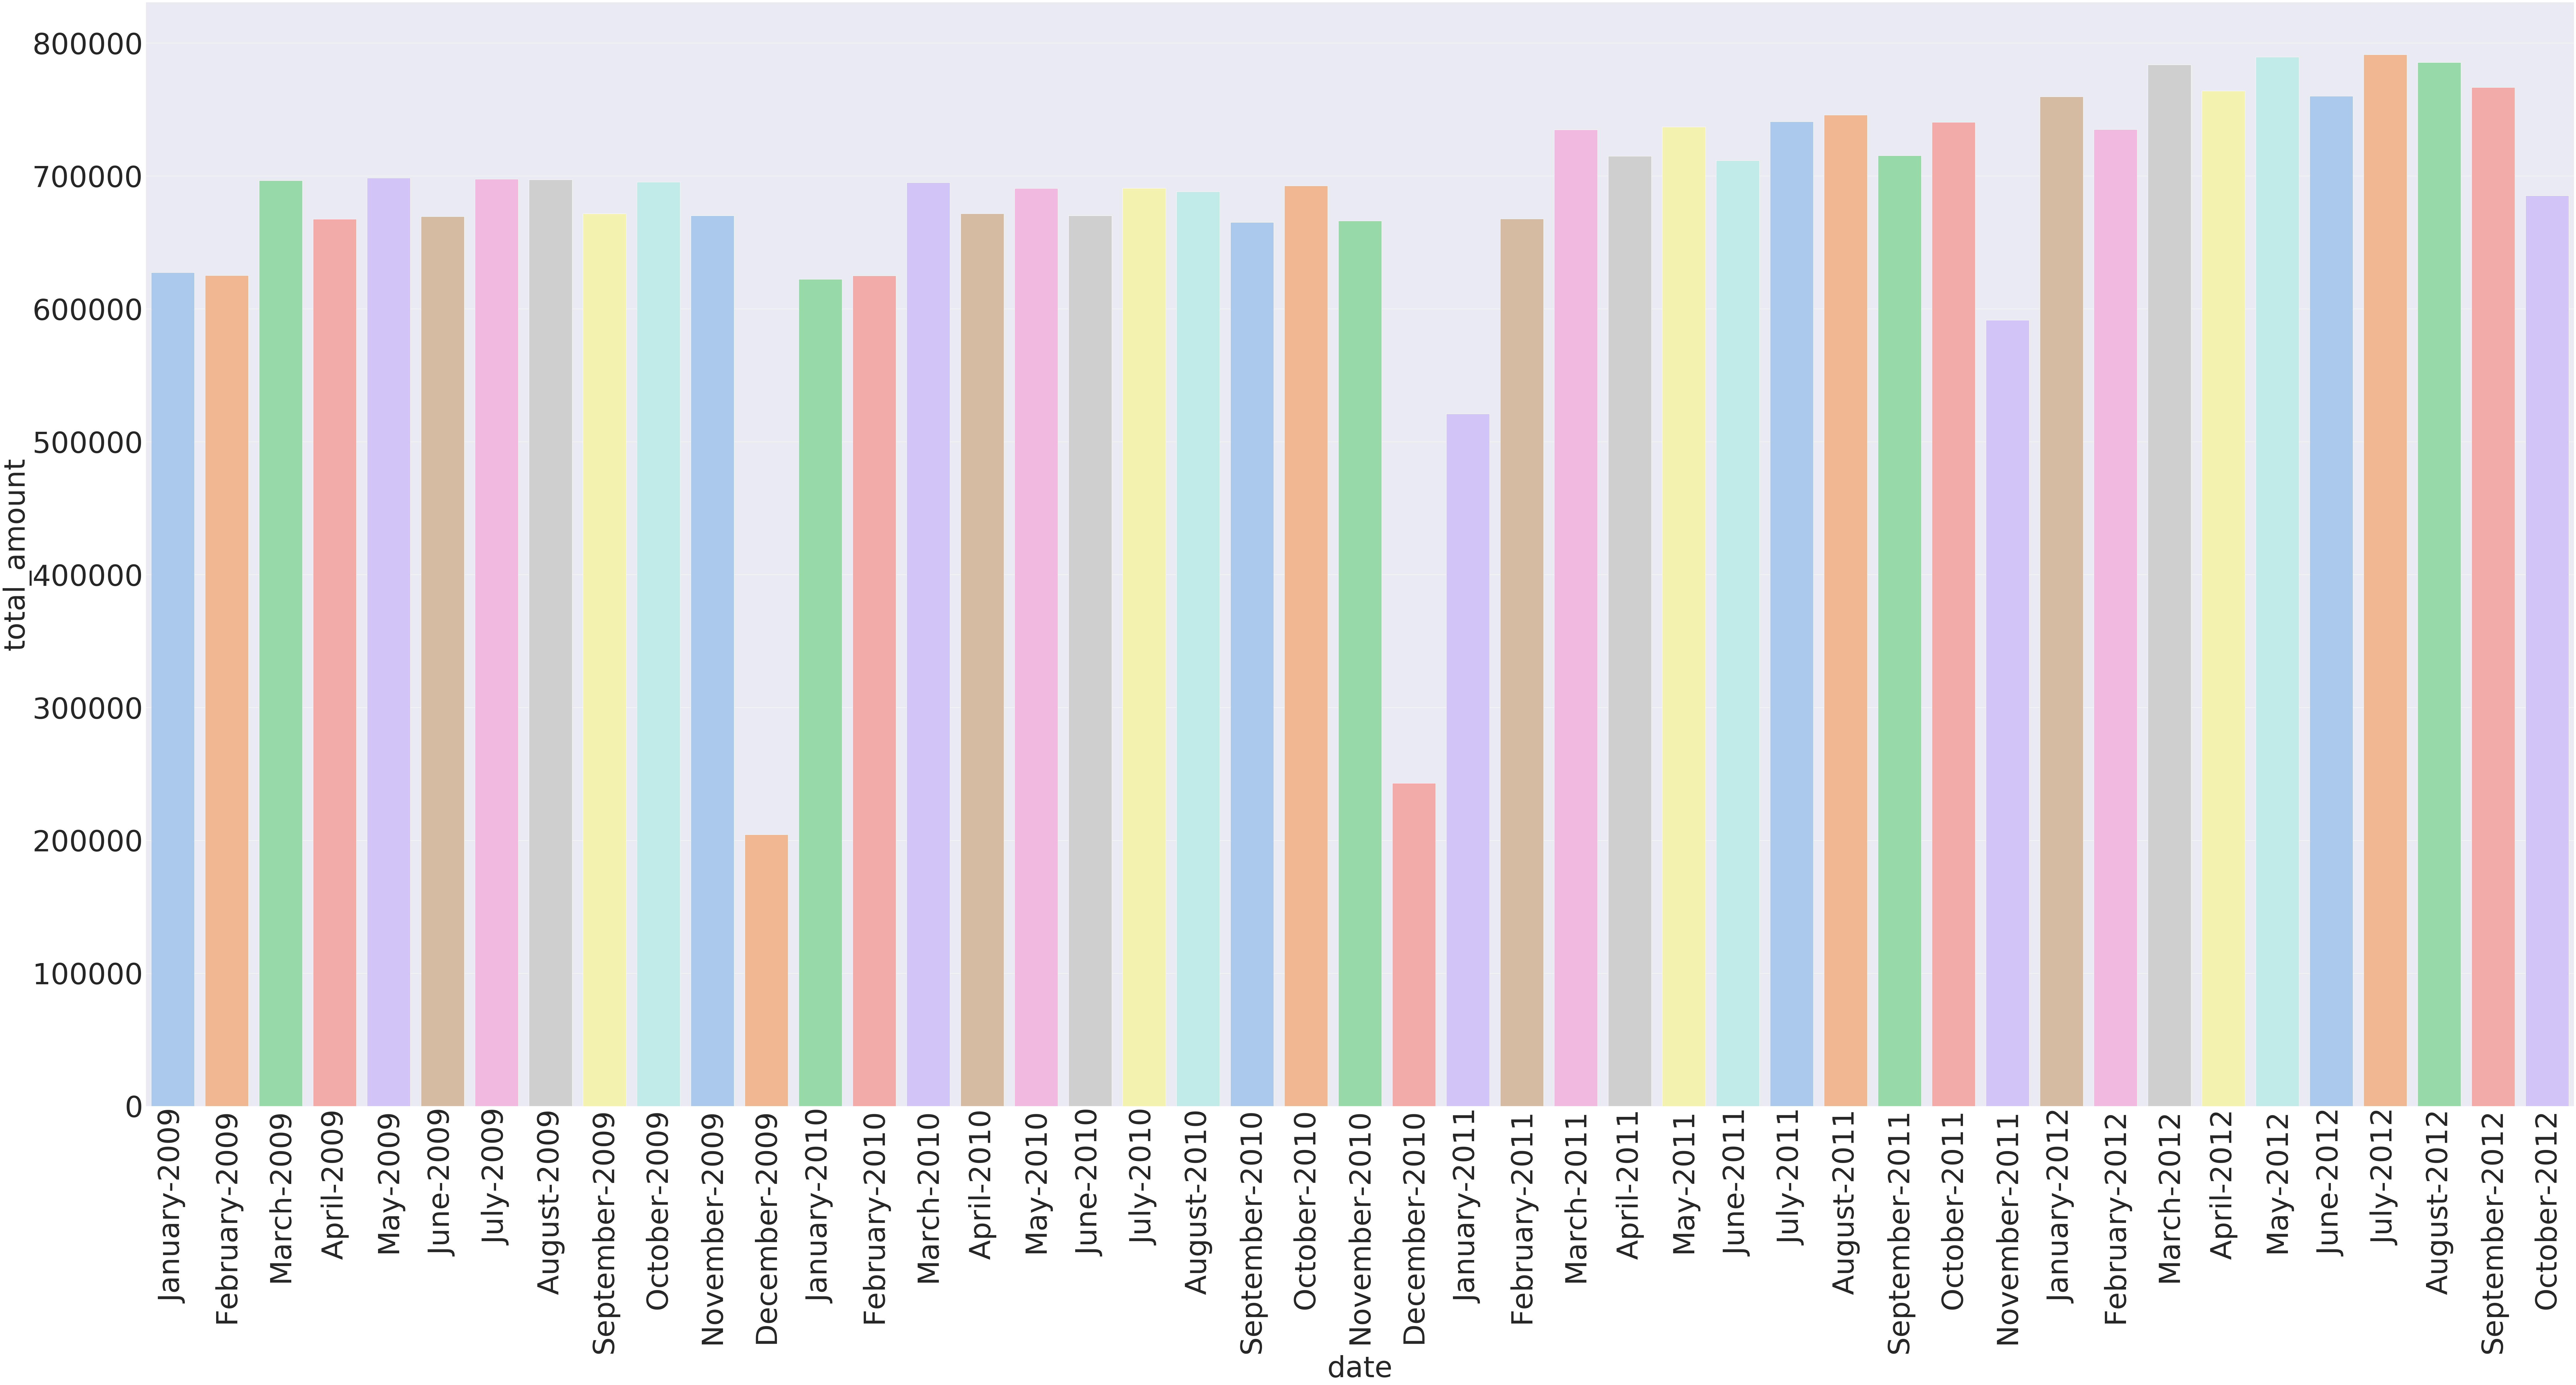

In [10]:
plt.figure(figsize=(150, 70))
sns.set(style="whitegrid")
rc={'font.size': 100, 'axes.labelsize': 100, 'legend.fontsize': 100, 
    'axes.titlesize': 100, 'xtick.labelsize': 100, 'ytick.labelsize': 100}
sns.set(rc=rc)
ax = sns.barplot(x='date', y='total_amount', data=monthly_distribution, palette="pastel")
r = plt.xticks(rotation=90)

### Faça um gráfico de série temporal contando a quantidade de gorjetas de cada dia, nos últimos 3 meses de 2012.

In [11]:
# Fetch Query Airflow
query_tips = f"""
    select date_trunc('day', to_date(pickup_datetime, 'YYYY-MM-DD')) as day_date
          ,count(tip_amount) as tip_count
          ,extract(month from date_trunc('month', to_date(pickup_datetime, 'YYYY-MM-DD'))) as month_number
          ,extract(year from date_trunc('month', to_date(pickup_datetime, 'YYYY-MM-DD'))) as year_date
    from nyc_taxi.nyctaxi_trips
    where extract(year from date_trunc('month', to_date(pickup_datetime, 'YYYY-MM-DD'))) = 2012
    and tip_amount > 0
    and extract(month from date_trunc('month', to_date(pickup_datetime, 'YYYY-MM-DD'))) >= 8
    group by day_date, year_date, month_number
    order by month_number desc;
"""
# Run Query
tips = pd.DataFrame(airflow_handler.fetch(query_tips))

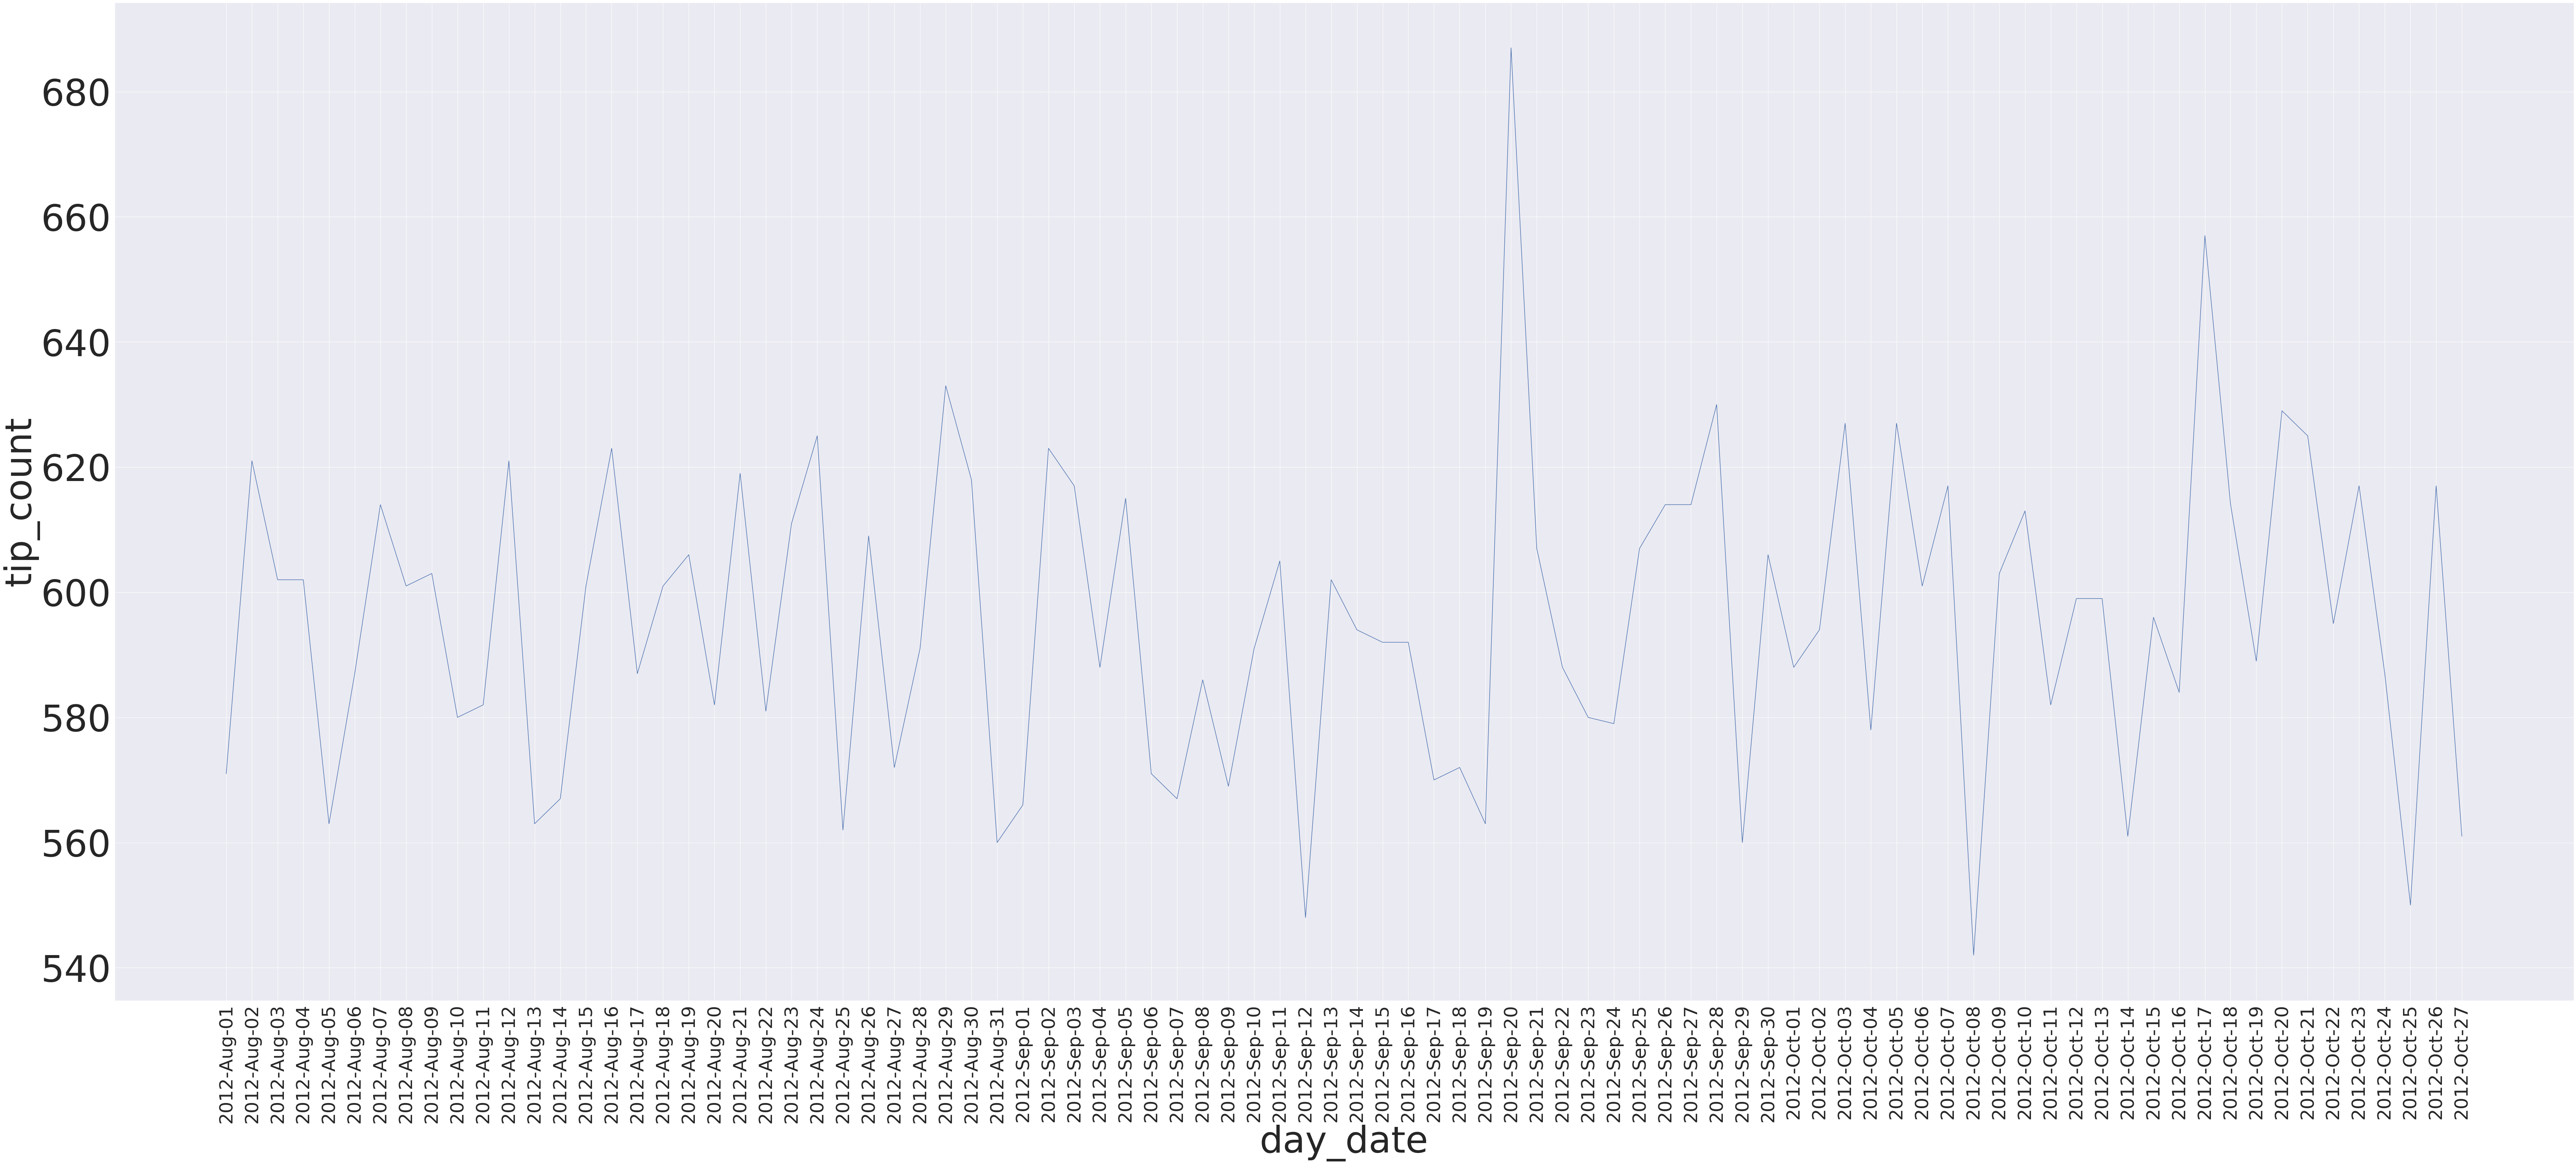

In [12]:
plt.figure(figsize=(120, 50))
ax = sns.set(style="whitegrid")
rc={'font.size': 100, 'axes.labelsize': 100, 'legend.fontsize': 100, 
    'axes.titlesize': 100, 'xtick.labelsize': 50, 'ytick.labelsize': 100}
ax = sns.set(rc=rc)
ax = sns.lineplot(x='day_date', y='tip_count', data=tips)
ax.set(xticks=tips['day_date'])
ax.xaxis.set_major_formatter(dates.DateFormatter("%Y-%b-%d"))
r = plt.xticks(rotation=90)

## Quesitos Bonus

### Qual o tempo médio das corridas nos dias de sábado e domingo;

In [13]:
# Fetch Query Airflow
query_avg_weekend = f"""
    select extract(month from date_trunc('month', to_date(pickup_datetime, 'YYYY-MM-DD'))) as month_number
          ,extract(year from date_trunc('month', to_date(pickup_datetime, 'YYYY-MM-DD'))) as year_number
          ,weekday
          ,diff_trip_seconds as diff_trip_minutes
    from nyc_taxi.nyctaxi_trips
    where weekday >= 5;
"""
# Run Query
avg_weekend = pd.DataFrame(airflow_handler.fetch(query_avg_weekend))

In [14]:
avg_weekend['month_number'] = avg_weekend['month_number'].apply(lambda data: int(data))
avg_weekend['year_number'] = avg_weekend['year_number'].apply(lambda data: int(data))
avg_weekend['month_number'] = avg_weekend['month_number'].apply(lambda data: calendar.month_abbr[data])
avg_weekend['weekday'] = avg_weekend['weekday'].apply(lambda data: calendar.day_name[data])

In [15]:
avg_weekend_calculate = avg_weekend.groupby(['month_number', 'year_number', 'weekday']).mean()
avg_weekend_calculate['diff_trip_seconds'] = avg_weekend_calculate['diff_trip_seconds'].apply(lambda data: round(data/60, 2))

In [16]:
print(f'Duracao media em minutos das viagens feitas nos finais de semana:')
avg_weekend_calculate

Duracao media em minutos das viagens feitas nos finais de semana:


diff_trip_seconds
month_number year_number weekday                    
Apr          2009        Saturday               9.02
                         Sunday                 8.95
             2010        Saturday               7.99
                         Sunday                 7.97
             2011        Saturday               9.02
                         Sunday                 8.99
             2012        Saturday               9.01
                         Sunday                 9.03
Aug          2009        Saturday               8.99
                         Sunday                 9.01
             2010        Saturday               8.01
                         Sunday                 7.99
             2011        Saturday               8.98
                         Sunday                 9.01
             2012        Saturday               8.98
                         Sunday                 8.98
Dec          2009        Saturday               9.05
                         Sunday                 9.03
             2010        Saturday               8.00
                         Sunday                 7.97
Feb          2009        Saturday               9.03
                         Sunday                 8.97
             2010        Saturday               8.02
                         Sunday                 7.98
             2011        Saturday               8.98
                         Sunday                 9.02
             2012        Saturday               9.01
                         Sunday                 9.00
Jan          2009        Saturday               8.99
                         Sunday                 9.02
             2010        Saturday               8.02
                         Sunday                 8.00
             2011        Saturday               8.99
                         Sunday                 8.97
             2012        Saturday               8.99
                         Sunday                 9.04
Jul          2009        Saturday               9.03
                         Sunday                 9.00
             2010        Saturday               8.04
                         Sunday                 7.99
             2011        Saturday               8.99
                         Sunday                 8.97
             2012        Saturday               8.97
                         Sunday                 9.01
Jun          2009        Saturday               8.99
                         Sunday                 8.96
             2010        Saturday               8.00
                         Sunday                 8.00
             2011        Saturday               8.98
                         Sunday                 8.98
             2012        Saturday               8.98
                         Sunday                 9.01
Mar          2009        Saturday               9.00
                         Sunday                 9.01
             2010        Saturday               8.01
                         Sunday                 7.98
             2011        Saturday               8.97
                         Sunday                 8.97
             2012        Saturday               9.00
                         Sunday                 8.98
May          2009        Saturday               8.99
                         Sunday                 8.97
             2010        Saturday               8.00
                         Sunday                 8.00
             2011        Saturday               9.04
                         Sunday                 8.97
             2012        Saturday               9.03
                         Sunday                 9.01
Nov          2009        Saturday               8.99
                         Sunday                 8.99
             2010        Saturday               8.01
                         Sunday                 8.03
             2011        Saturday               8.99
                         Sunday                 9.01
Oct    

### Fazer uma visualização em mapa com latitude e longitude de ​ pickups and ​ dropoffs ​ no ano de 2010

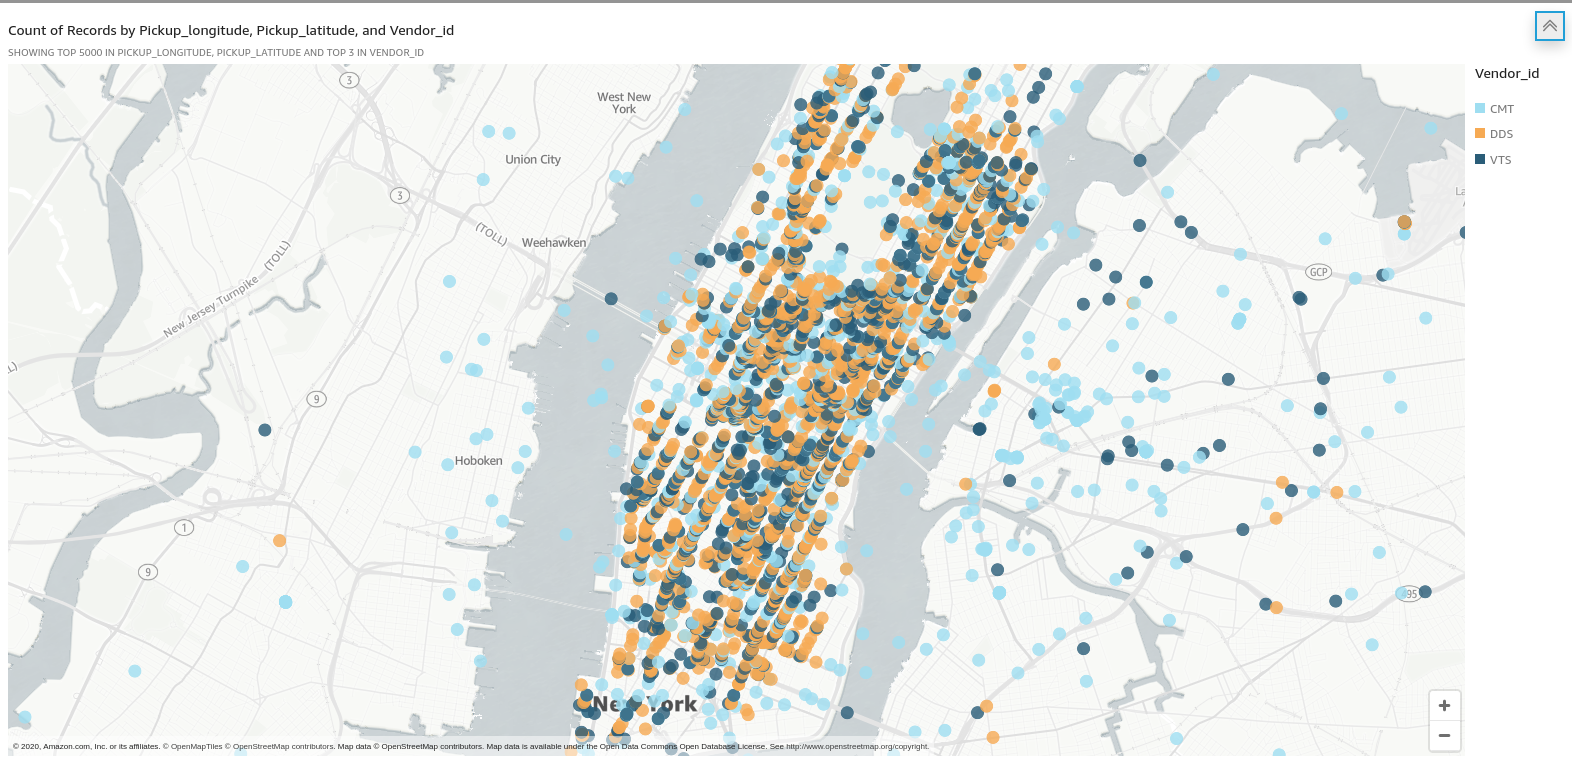

In [17]:
Image(filename='map_pick_up.png') 

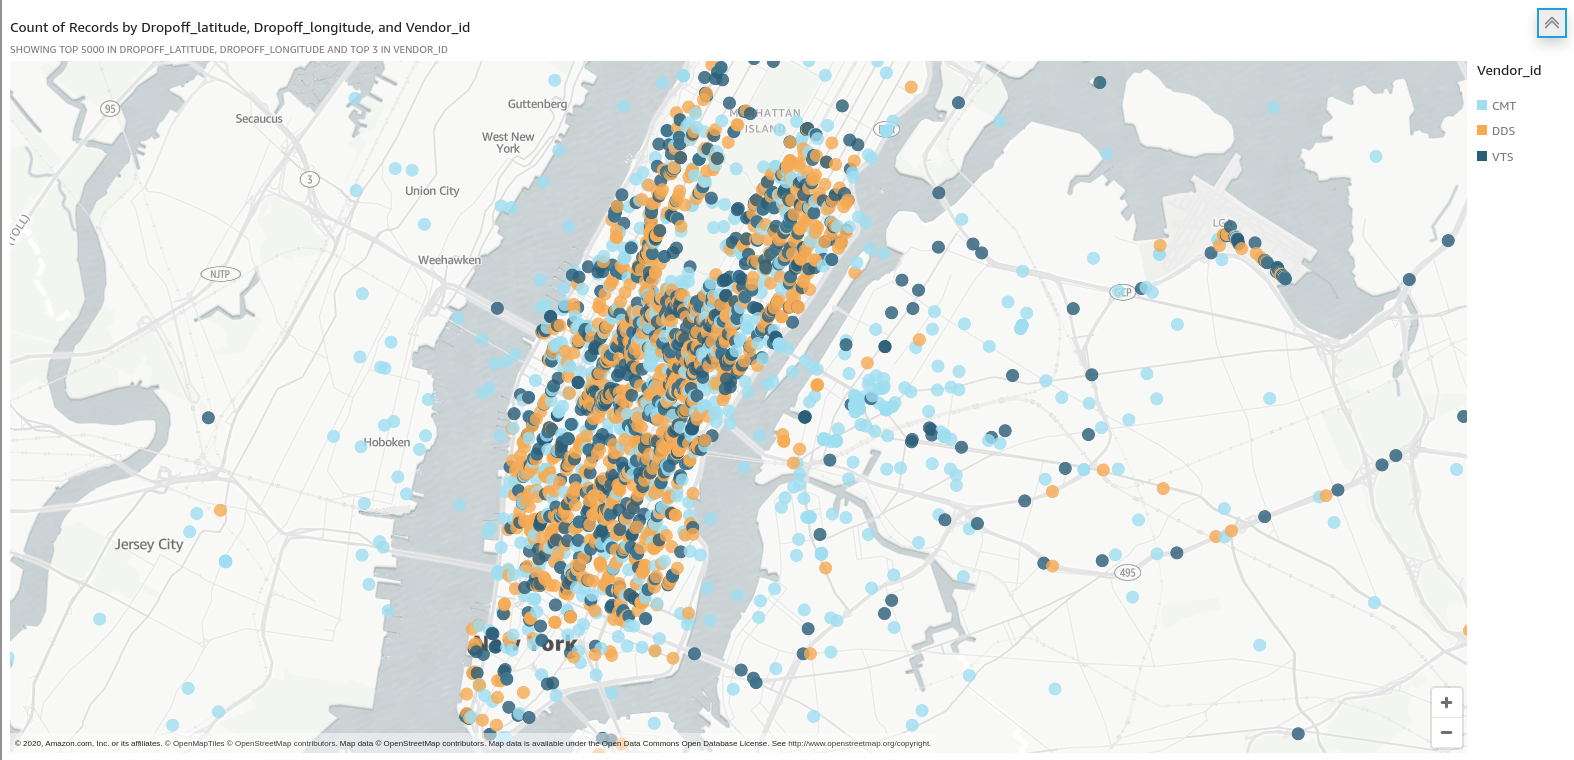

In [18]:
Image(filename='map_drop_off.png') 

### Conseguir provisionar todo seu ambiente em uma cloud pública, de preferência ​ AWS ​ .